 Programmed by : Marvin Fernandes

Date created : 2 May 2020

Last Modified : 12 August 2020

In [1]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D, Conv2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import tensorflow as tf
from matplotlib import pyplot
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
# Check version of tensorflow 
# for this demostration Tf.version should be v1.14 - v1.15
tf.__version__

'1.15.0'

In [16]:
# Path To Image Directory
PATH = "catsndog/"

# Image Shape to Be trained
sz=60
# Batch size to feed in the model
batch_size=16

In [40]:
# Train Dataset
train_data_dir = f'{PATH}train'

#Validation Dataset
validation_data_dir = f'{PATH}valid'

In [41]:
train_datagen = ImageDataGenerator(shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   rotation_range=30,
                                   #rescale=1./255,
                                  )

test_datagen = ImageDataGenerator() #rescale=1./255,

In [42]:
# Available options for data augmentation

# ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
#     vertical_flip=False, rescale=None, preprocessing_function=None,
#     data_format=None, validation_split=0.0, dtype=None
# )

In [43]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(sz, sz),
                                                    batch_size=batch_size, 
                                                    class_mode='binary'
                                                   )

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        shuffle=False,
                                                        target_size=(sz, sz),
                                                        batch_size=batch_size, class_mode='binary'
                                                       )  

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [44]:
# Check Category of classes
train_generator.class_indices

{'Cats': 0, 'Dogs': 1}

In [45]:
len(train_generator.class_indices)

2

In [46]:
train_generator.n

2000

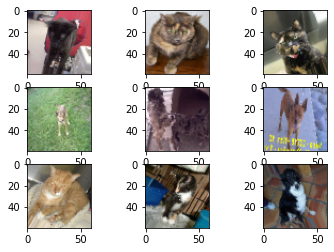

In [47]:
# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    x,y = train_generator.next()
    # convert to unsigned integers for viewing
    image = x[0].astype('uint8')
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [94]:
image.shape

(60, 60, 3)

In [95]:
# #create model
# model = Sequential()  # model type

# #add model layers
# model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(sz, sz, 1)))
# model.add(Conv2D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
# model.add(Flatten())
# model.add(Dense(2, activation='softmax'))

# model_final = model

In [96]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape = (sz, sz, 3))

#### Freeze the Pretrained Model

In [52]:
# #Freeze All layers in Pretarined Model Except Batch Normalization Layers
# for layer in base_model.layers:
#     if layer.__class__.__name__ != "BatchNormalization":
#         layer.trainable = False

In [53]:
#base_model.summary()

In [54]:
#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(124, activation="relu")(x)
predictions = Dense(len(train_generator.class_indices), activation="softmax")(x)

In [55]:
# creating the final model by combining pretrained model and custom layers.
model_final = Model(inputs = base_model.input, outputs = predictions)

In [56]:
# compile the model 
model_final.compile(loss = "sparse_categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [57]:
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 66, 66, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 30, 30, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 30, 30, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

conv3_block4_2_relu (Activation (None, 8, 8, 128)    0           conv3_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_3_conv (Conv2D)    (None, 8, 8, 512)    66048       conv3_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 8, 8, 512)    2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 8, 8, 512)    0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 8, 8, 512)    0           conv3_block4_add[0][0]           
__________

In [58]:
# simple early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1)

In [59]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [60]:
#visualize model if required
# tf.keras.utils.plot_model(model_final, show_shapes=True)

In [61]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [62]:
history=model_final.fit_generator(train_generator,steps_per_epoch=train_generator.n // batch_size,epochs=4,
                                  validation_data=validation_generator,
                                  validation_steps=validation_generator.n // batch_size,
                                  verbose=1, 
                                  #callbacks=[es, mc]
                                 )

Epoch 1/4
125/125 [==============================] - 329s 3s/step - loss: 1.5535 - acc: 0.5465 - val_loss: 5760.2594 - val_acc: 0.4792
Epoch 2/4
125/125 [==============================] - 310s 2s/step - loss: 0.8560 - acc: 0.5715 - val_loss: 1.0499 - val_acc: 0.6406
Epoch 3/4
125/125 [==============================] - 312s 2s/step - loss: 0.7063 - acc: 0.6500 - val_loss: 19.1191 - val_acc: 0.5417
Epoch 4/4
125/125 [==============================] - 307s 2s/step - loss: 0.6513 - acc: 0.6855 - val_loss: 0.5863 - val_acc: 0.6719


In [186]:
# #Fine Tune Model if Required (Optional)

# model_final.trainable = True

# # It's important to recompile your model after you make any changes
# # to the `trainable` attribute of any inner layer, so that your changes
# # are take into account
# model_final.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

In [ ]:
# # Train end-to-end. Be careful to stop before you overfit!
# history=model_final.fit_generator(train_generator,steps_per_epoch=train_generator.n // batch_size,epochs=3,
#                                   validation_data=validation_generator,
#                                   validation_steps=validation_generator.n // batch_size,
#                                   verbose=1 
#                                   #callbacks=[es, mc]
#                                  )

In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [87]:
#Validation Dataset
# validation_generator = test_datagen.flow_from_directory(validation_data_dir,
#                                                         #rescale=1./255,
#                                                         shuffle=False,
#                                                         target_size=(sz, sz),
#                                                         batch_size = 1,
#                                                         class_mode='binary'
#                                                        )

In [63]:
#Test Dataset
test_data_dir = f'{PATH}test'
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  #rescale=1./255,
                                                  shuffle=False,
                                                  target_size=(sz, sz),
                                                  batch_size = 1,
                                                  class_mode='binary'
                                                   )

Found 200 images belonging to 2 classes.


In [64]:
# Enter the dataset to make prediction
make_prediction = test_generator # validation_generator or test_generator

In [103]:
STEP_SIZE_TEST = make_prediction.n // make_prediction.batch_size
make_prediction.reset()

In [ ]:
#Make Prediction
y_pred =model_final.predict_generator(make_prediction, steps= STEP_SIZE_TEST, verbose=1)

In [104]:
#Prerequisite to save to CSV
y_pred_ind = np.argmax(y_pred, axis=1)

200/200 [==============================] - 14s 72ms/step


In [66]:
#Generate Confusion Matrix
cm =confusion_matrix(make_prediction.classes, y_pred_ind)  # validation_generator or test_generator

In [91]:
class_indices_csv = (validation_generator.class_indices)
#reverse dictionary
class_indices_csv = dict((v,k) for k,v in class_indices_csv.items())
predictions = [class_indices_csv[k] for k in y_pred_ind]

[[Text(0, 0.5, 'Cats'), Text(0, 1.5, 'Dogs')]]

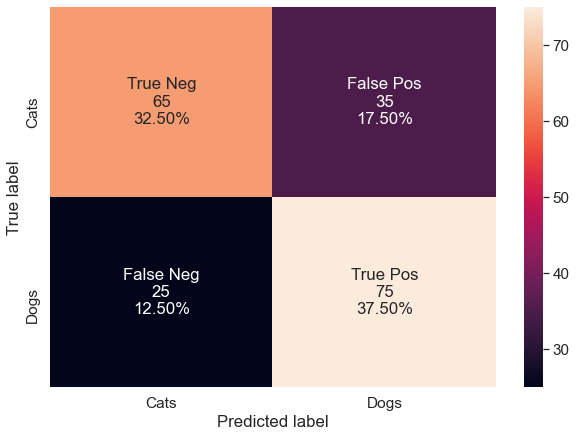

In [92]:
import seaborn as sns
import numpy as np

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
group_names  = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names ,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
g = sns.heatmap(cm, annot=labels, fmt="")
plt.ylabel('True label')
plt.xlabel('Predicted label')

g.set(xticklabels=[str(class_indices_csv[0]),str(class_indices_csv[1])])
g.set(yticklabels=[str(class_indices_csv[0]),str(class_indices_csv[1])])

In [70]:
import pandas as pd

In [76]:
validation_generator.class_indices

{'Cats': 0, 'Dogs': 1}

In [73]:
y_class= make_prediction.classes

In [87]:
filenames=make_prediction.filenames
#Create Structure to save to CSV
df_analysis=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred_ind,
                      "Classification":y_class,
                      class_indices_csv[0]:y_pred[:,0],
                      class_indices_csv[1]:y_pred[:,1]
                     })
#Save to CSV
df_analysis.to_csv("resultstranferlearning.csv",index=False)

In [93]:
#Save Entire Model
model_final.save('catsanddogsmodel.h5')